## 사용자의 리뷰, 제품 카테고리의 자세함 설명, 브랜드 네임, 아이템 상태에 따라 제품의 올바른 가격을 제안하는 것이 목표

In [25]:
!pip install kaggle
from google.colab import files
files.upload()

{}

In [26]:
# import os 
# os.getcwd()
# os.chdir("/content/drive/MyDrive/kaggle_code/")

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# # Permission Warning 이 일어나지 않도록 
# !chmod 600 ~/.kaggle/kaggle.json
# # 본인이 참가한 모든 대회 보기 
# !kaggle competitions list
# ! kaggle competitions download -c mercari-price-suggestion-challenge
# import os 
# os.getcwd()
# os.chdir("/content/drive/MyDrive/kaggle_code/")

In [29]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline 

import math


from subprocess import check_output
print(check_output(["ls", "/content/drive/MyDrive/kaggle_code/week_34"]).decode("utf8"))

sample_submission.csv.7z
sample_submission_stg2.csv.zip
test (1).tsv
test_stg2.tsv
test_stg2.tsv.zip
test.tsv
test.tsv.7z
train.tsv
train.tsv.7z



In [30]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [31]:
# 데이터 불러오기
print("Loading data...")
train = pd.read_table("/content/drive/MyDrive/kaggle_code/week_34/train.tsv")
test = pd.read_table("/content/drive/MyDrive/kaggle_code/week_34/test.tsv")
print(train.shape)
print(test.shape)

Loading data...
(1482535, 8)
(693359, 7)


# 결측치 처리

In [32]:
print("Handling missing values...")
def handle_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True) # 결측치를 misssing으로 처리
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)
print(train.shape)
print(test.shape)

Handling missing values...
(1482535, 8)
(693359, 7)


In [33]:
print("Handling categorical variables...")
le = LabelEncoder()

le.fit(np.hstack([train.category_name, test.category_name])) # 배열을 옆으로 붙이는것
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)
del le

train.head(3)

Handling categorical variables...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...


In [34]:
len(raw_text) 

2965070

In [35]:
len(train.item_description.str.lower())

1482535

In [36]:
len(train.name.str.lower())

1482535

In [37]:
print("Text to seq process...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()]) # 소문자로 변경 및 붙이기

print("   Fitting tokenizer...")
tok_raw = Tokenizer() # 토크나이저
tok_raw.fit_on_texts(raw_text) # 문자 데이터를 입력받아서 리스트의 형태로 변환한.
print("   Transforming text to seq...")

train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.str.lower()) #메서드는 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환한다
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower()) # 아이템 설명을 시퀀스 형태로
train["seq_name"] = tok_raw.texts_to_sequences(train.name.str.lower()) # 아이템 이름을 시퀀스 형태로
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())
train.head(3)

Text to seq process...
   Fitting tokenizer...
   Transforming text to seq...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"


In [38]:
# 시퀀스 변수 분석 - 길이
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x:len(x))), np.max(test.seq_name.apply(lambda x : len(x)))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test.seq_item_description.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

max name seq 17
max item desc seq 269


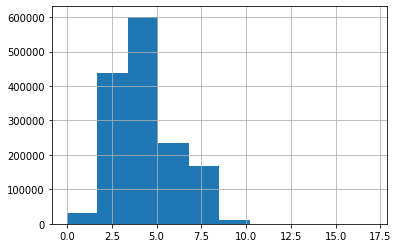

In [39]:
train.seq_name.apply(lambda x:len(x)).hist()

In [42]:
train

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"
3,3,Leather Horse Statues,1,503,5265,35.0,1,New with tags. Leather horses. Retail for [rm]...,"[5, 9, 61, 178, 6528, 230, 3, 21, 166, 1085, 2...","[178, 2610, 14248]"
4,4,24K GOLD plated rose,1,1204,5265,44.0,0,Complete with certificate of authenticity,"[807, 9, 6888, 11, 1997]","[4884, 104, 1032, 280]"
...,...,...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,1188,1792,20.0,1,"Lace, says size small but fits medium perfectl...","[192, 690, 6, 44, 38, 160, 69, 710, 165, 36, 3...","[13, 573, 1667, 82]"
1482531,1482531,Little mermaid handmade dress,2,651,1379,14.0,0,Little mermaid handmade dress never worn size 2t,"[156, 1321, 693, 82, 36, 30, 6, 1000]","[156, 1321, 693, 82]"
1482532,1482532,21 day fix containers and eating plan,2,916,5265,12.0,0,"Used once or twice, still in great shape.","[31, 96, 23, 356, 121, 7, 39, 385]","[293, 117, 1526, 2496, 1, 6764, 3693]"
1482533,1482533,World markets lanterns,3,503,5265,45.0,1,There is 2 of each one that you see! So 2 red ...,"[240, 10, 22, 11, 166, 46, 78, 18, 138, 76, 22...","[1370, 21306, 11181]"


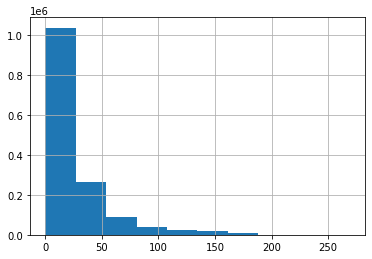

In [43]:
train.seq_item_description.apply(lambda x : len(x)).hist()

In [44]:
# embedding 최대값
# histograms에 기반하여 다음 길이 결정
max_name_seq = 10
max_item_desc_seq = 75
max_text = np.max([np.max(train.seq_name.max()), np.max(test.seq_name.max()), 
                   np.max(train.seq_item_description.max()), np.max(test.seq_item_description.max())])+2  # InvalidArgumentError: indices[66,9] = 321997 is not in [0, 321997) 에러때문에 +2, +1 작업

max_category = np.max([train.category_name.max(), test.category_name.max()])+1
max_brand = np.max([train.brand_name.max(), test.brand_name.max()])+1
max_condition = np.max([train.item_condition_id.max(), test.item_condition_id.max()])+1                  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff76cf7da10>]],
      dtype=object)

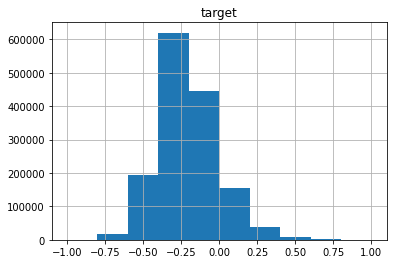

In [53]:
train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(np.array(train.target).reshape(-1, 1))
pd.DataFrame(train.target).hist()

In [55]:
dtrain, dvalid = train_test_split(train, random_state=123, train_size=0.99)
print(dtrain.shape)
print(dvalid.shape)

(1467709, 11)
(14826, 11)


In [56]:
# 케라스 데이터 정의

from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
  X={
      'name' : pad_sequences(dataset.seq_name, maxlen=max_name_seq), # 패딩작업
     'item_desc':pad_sequences(dataset.seq_item_description, maxlen=max_item_desc_seq),
     'brand_name':np.array(dataset.brand_name),
     'category_name':np.array(dataset.category_name),
     'item_condition':np.array(dataset.item_condition_id),
     'num_vars':np.array(dataset[['shipping']])
  }
  return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

In [61]:
# 모델링
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K


def get_callbacks(filepath, patience=2):
  es = EarlyStopping('val_loss', patience=patience, mode='min') # early stopping
  msave = ModelCheckpoint(filepath, save_best_only=True)
  return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))


def get_model():
  # 파라메터
  dr_r = 0.1

  # input
  name=Input(shape=[X_train["name"].shape[1]], name='name')
  item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
  brand_name = Input(shape=[1], name="brand_name")
  category_name = Input(shape=[1], name="category_name")
  item_condition = Input(shape=[1], name="item_condition")
  num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")

  # 임베딩 레이어 임베딩 벡터를 고정시키기 위해서
  emb_name = Embedding(max_text, 50)(name) #name 데이터를 max_text, 50사이즈로 변환
  emb_item_desc = Embedding(max_text, 50)(item_desc)
  emb_brand_name = Embedding(max_brand, 10)(brand_name)
  emb_category_name = Embedding(max_category, 10)(category_name)
  emb_item_condition = Embedding(max_condition, 5)(item_condition)

  # rnn
  rnn_layer1 = GRU(16) (emb_item_desc) # item을 GRU에 투입
  rnn_layer2 = GRU(8) (emb_name) # name을 GRU에 투입

  # main layer
  main_l = concatenate([
                        Flatten()(emb_brand_name),
                        Flatten()(emb_category_name),
                        Flatten()(emb_item_condition),
                        rnn_layer1,
                        rnn_layer2,
                        num_vars
  ])

  main_l = Dropout(dr_r)(Dense(128)(main_l))
  main_l = Dropout(dr_r)(Dense(64)(main_l))

  # output
  output = Dense(1, activation='linear')(main_l)

  #model
  model = Model([name, item_desc, brand_name
                  , category_name, item_condition, num_vars], output)
  model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
  
  return model

    
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 category_name (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 item_condition (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                              

In [62]:
BATCH_SIZE = 20000
epochs = 5

model = get_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Epoch 1/5
74/74 [==============================] - 28s 241ms/step - loss: 0.0273 - mae: 0.1258 - rmsle_cust: 0.0153 - val_loss: 0.0180 - val_mae: 0.1018 - val_rmsle_cust: 0.0135
Epoch 2/5
74/74 [==============================] - 17s 226ms/step - loss: 0.0177 - mae: 0.1006 - rmsle_cust: 0.0132 - val_loss: 0.0162 - val_mae: 0.0963 - val_rmsle_cust: 0.0127
Epoch 3/5
74/74 [==============================] - 17s 227ms/step - loss: 0.0158 - mae: 0.0949 - rmsle_cust: 0.0125 - val_loss: 0.0157 - val_mae: 0.0957 - val_rmsle_cust: 0.0125
Epoch 4/5
74/74 [==============================] - 17s 227ms/step - loss: 0.0148 - mae: 0.0918 - rmsle_cust: 0.0122 - val_loss: 0.0153 - val_mae: 0.0936 - val_rmsle_cust: 0.0123
Epoch 5/5
74/74 [==============================] - 17s 226ms/step - loss: 0.0142 - mae: 0.0898 - rmsle_cust: 0.0119 - val_loss: 0.0153 - val_mae: 0.0942 - val_rmsle_cust: 0.0123


In [63]:
# 모델 평가
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

# 절대값, log error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))

 RMSLE error on dev test: 0.4926026359477031


In [64]:
#예측
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

submission = test[["test_id"]]
submission["price"] = preds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
submission.to_csv("./myNNsubmission.csv", index=False)
submission.price.hist()

## 개선점
- embedding 요소 증가
- 배치 사이즈 줄이기
- batch  normalization 투입
- LSTM, 양방향 RNN, RNN 쌓기
- 더 깊은 dense layer

# 배워갔으면 하는 점
카테고리 변수 같은 경우 embedding layer로 변경하면 하나의 숫자 변수를 넣는 것이다. 그런데 왜 사용하냐면, 단어를 고정 길이 벡터로 변환하여 학습공간 차원을 고정시켜 학습 중 비슷한 의미를 가진 단어를 더 가까운 벡터값을 얻도록 하여, 비슷한 단어는 가깝게, 먼 단어는 멀리 떨어지는 효과를 얻음

<br>
Tokenizer 경우 texts_to_sequences를 통해 텍스트를 시퀀스로 
<br>
fit_on_texts을 통해 텍스트를 리스트로 변환하는 기능을 가진다는 점